# EDA

> KSSL, IAEA, WCRC spectra in PCA/UMap spaces

In [ ]:
import os
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from fastcore.xtras import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from mirzai.data.transform import TakeDerivative, SNV, DropSpectralRegions

In [ ]:
# Configure data viz. (Matplotlib)
PRIMARY_COLOR = '#333'
ACCENT_COLOR = '#CA0020'

params = {
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'figure.titleweight': 'normal',
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.axisbelow': True,
    'axes.grid': True,
    'grid.linewidth': 1,
    'grid.linestyle': '--',
    'font.size': 11,
    'axes.labelsize': 11,
    'axes.labelpad': 5, 
    'axes.labelweight': 'normal',
    'axes.titleweight': 'normal',
    'text.usetex': False,
    }

mpl.rcParams.update(params)

In [ ]:
def plot_spectra(X, X_names, sample=50, alpha=0.8, color='#333', figsize=(20, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    idx = np.random.randint(X.shape[0], size=sample)
    ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.locator_params(axis="x", nbins=20)
    plt.xlabel('Wavenumber')
    plt.ylabel('Absorbance')
    _ = ax.plot(X_names, X[idx, :].T, lw=1, c=color, alpha=alpha)

In [ ]:
def plot_pca_variance(cumsum, n_components):
    # Plotting Cumulated Explained Variance against number of Principam Comoponents
    fig, ax = plt.subplots(figsize=(10, 3))
    plt.xlabel('Nb. of PCA components')
    plt.ylabel('Explained Variance')
    ax.set_xticks(range(1, n_components+1))
    ax.plot(range(1, n_components+1), cumsum, marker='.', markersize=10, 
            markeredgewidth=2, markeredgecolor='white', color='black', lw=1)

## 1.Data loading

In [ ]:
t = Path('../../_data/kssl-mirs-v2/')

In [ ]:
t.ls()

(#46305) [Path('../../_data/kssl-mirs-v2/180338'),Path('../../_data/kssl-mirs-v2/172221'),Path('../../_data/kssl-mirs-v2/177753'),Path('../../_data/kssl-mirs-v2/184798'),Path('../../_data/kssl-mirs-v2/53759'),Path('../../_data/kssl-mirs-v2/74947'),Path('../../_data/kssl-mirs-v2/176681'),Path('../../_data/kssl-mirs-v2/1855'),Path('../../_data/kssl-mirs-v2/175004'),Path('../../_data/kssl-mirs-v2/34499')...]

In [ ]:
# Loading KSSL
wns = np.arange(4000, 600, -2)
path = Path('../../_data/kssl-mirs-v2/')
X_metadata = {'smp_id': [], 'spec_id': []}
X, spec_ids, smp_ids = [], [], []

for smp_id in tqdm(os.listdir(path)):
    fnames = [f for f in os.listdir(path / smp_id) if f != 'target.csv']
    for fname in fnames:
        smp_ids.append(int(smp_id))
        spec_ids.append(fname)
        spectrum = pd.read_csv(path / smp_id / fname)['absorbance'].values
        X.append(spectrum)

100%|███████████████████████████████████████████████████████████| 46305/46305 [02:26<00:00, 316.65it/s]


In [ ]:
X, spec_ids, smp_ids = [np.array(ds) for ds in [X, spec_ids, smp_ids]]

In [ ]:
# Sub-sample
n_samples = 1000
idxs = np.random.choice(len(X), 1000)

In [ ]:
def normalize(X):
    mean = np.mean(X, axis=0, keepdims=True)
    std = np.std(X, axis=0, keepdims=True)
    return (X - mean) / std
    
normalize(X[:10, :]).shape

(10, 1700)

In [ ]:
np.mean(X[0,:])

0.8295293741381742

(array([[ 12.,  40., 101., ..., 615., 146.,  37.],
        [ 12.,  40., 101., ..., 616., 146.,  37.],
        [ 12.,  40., 100., ..., 615., 146.,  37.],
        ...,
        [  0., 126., 109., ..., 287.,  21.,   3.],
        [  0., 129., 110., ..., 285.,  27.,   3.],
        [  0., 131., 111., ..., 296.,  31.,   5.]]),
 array([-10.42648983,  -8.4512186 ,  -6.47594737,  -4.50067614,
         -2.52540491,  -0.55013368,   1.42513755,   3.40040878,
          5.37568001,   7.35095125,   9.32622248]),
 <a list of 1700 BarContainer objects>)

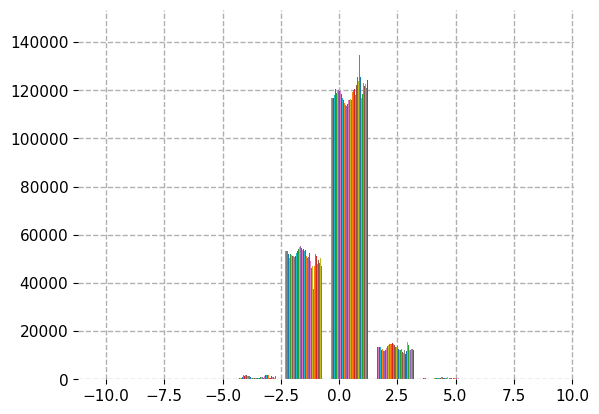

In [ ]:
plt.hist(normalize(X))

In [ ]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

g_mean(X[0,:])

0.7082722843707495

In [ ]:
np.median(X[0,:])

0.8624547644594247

In [ ]:
np.max(X)

3.081230971635986

In [ ]:
g_mean(X

In [ ]:
np.power(-X, 10)

array([[1.78722735e-08, 1.81500712e-08, 1.83604346e-08, ...,
        5.69715486e+01, 5.51724700e+01, 5.39243078e+01],
       [2.56633655e-08, 2.59552131e-08, 2.62079862e-08, ...,
        7.11491205e+01, 6.86245953e+01, 6.65071755e+01],
       [2.08658627e-08, 2.11723167e-08, 2.14243169e-08, ...,
        6.11605498e+01, 5.88603175e+01, 5.73438204e+01],
       ...,
       [3.32874740e-07, 3.40155820e-07, 3.47149738e-07, ...,
        1.35043798e+02, 1.26670777e+02, 1.19761862e+02],
       [1.80762661e-07, 1.85511216e-07, 1.90121520e-07, ...,
        8.26807690e+01, 7.60562428e+01, 7.06827432e+01],
       [7.48952127e-08, 7.71696153e-08, 7.92780751e-08, ...,
        8.40326585e+01, 7.83846819e+01, 7.39045839e+01]])

(array([[6.30000e+01, 5.18000e+02, 1.39142e+05, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [6.30000e+01, 5.18000e+02, 1.38975e+05, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [6.30000e+01, 5.16000e+02, 1.38827e+05, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        ...,
        [0.00000e+00, 0.00000e+00, 1.30000e+01, ..., 4.03300e+03,
         9.80000e+01, 5.00000e+00],
        [0.00000e+00, 0.00000e+00, 1.20000e+01, ..., 3.62000e+03,
         9.50000e+01, 5.00000e+00],
        [0.00000e+00, 0.00000e+00, 1.20000e+01, ..., 3.28800e+03,
         8.90000e+01, 5.00000e+00]]),
 array([-0.89074836, -0.49355043, -0.0963525 ,  0.30084544,  0.69804337,
         1.0952413 ,  1.49243924,  1.88963717,  2.2868351 ,  2.68403304,
         3.08123097]),
 <a list of 1700 BarContainer objects>)

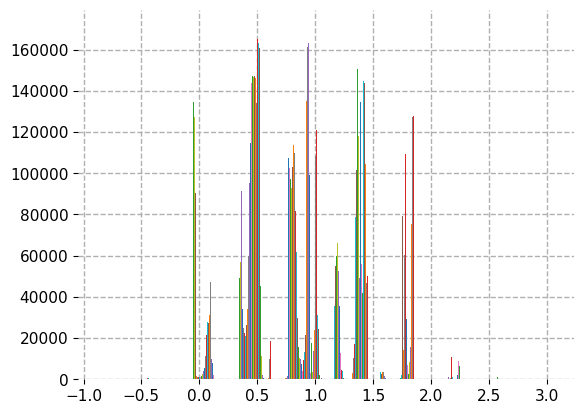

In [ ]:
plt.hist(X)

In [ ]:
# A = log10(1/T)
# 10**A = 1/T
# T = 1/(10**A)

In [ ]:
Xt = 1/(10**X)

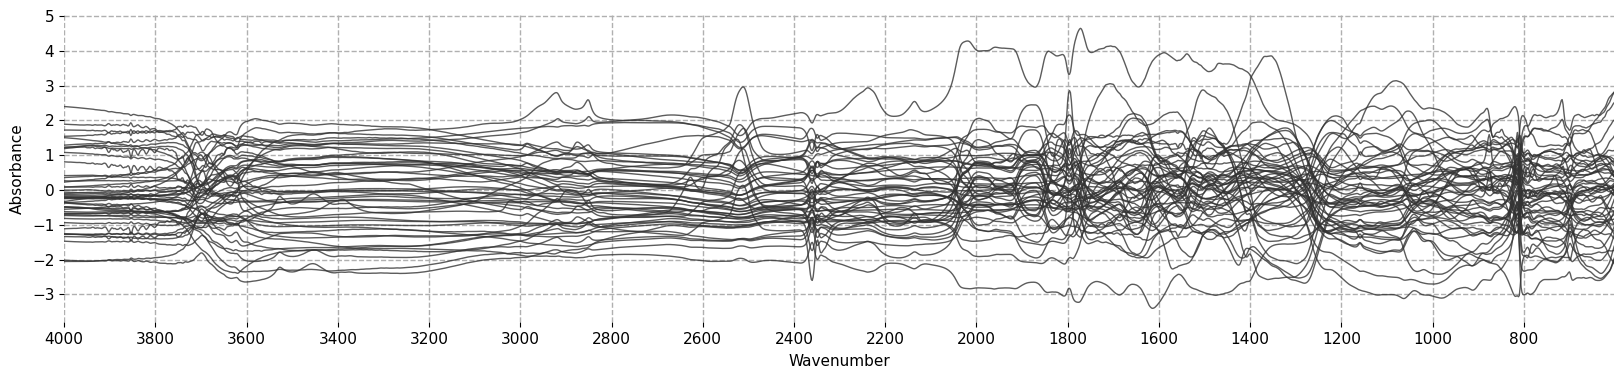

In [ ]:
plot_spectra(normalize(X[100:, :]), wns)

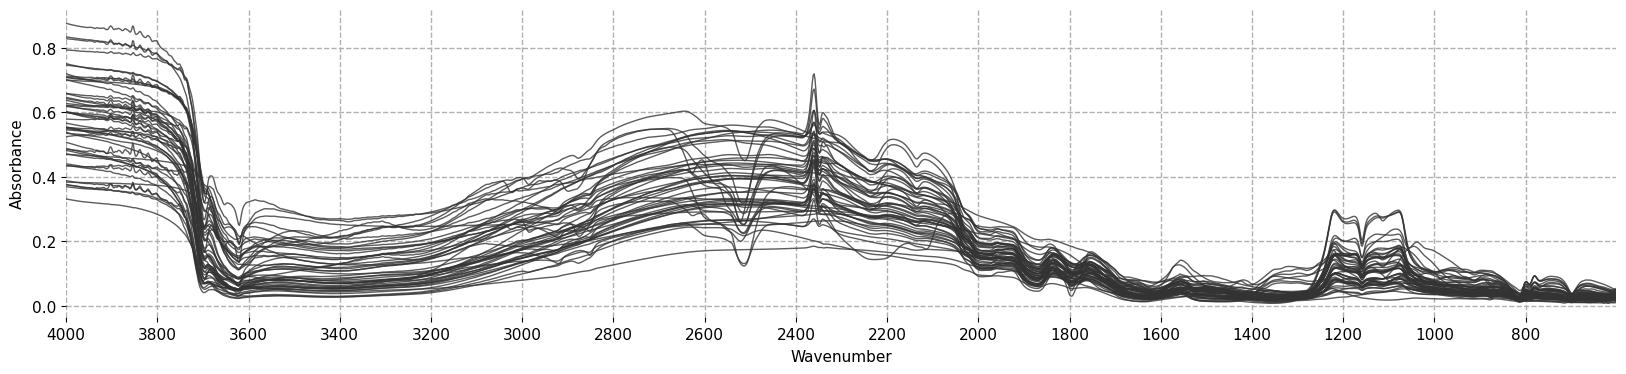

In [ ]:
plot_spectra(Xt, wns)

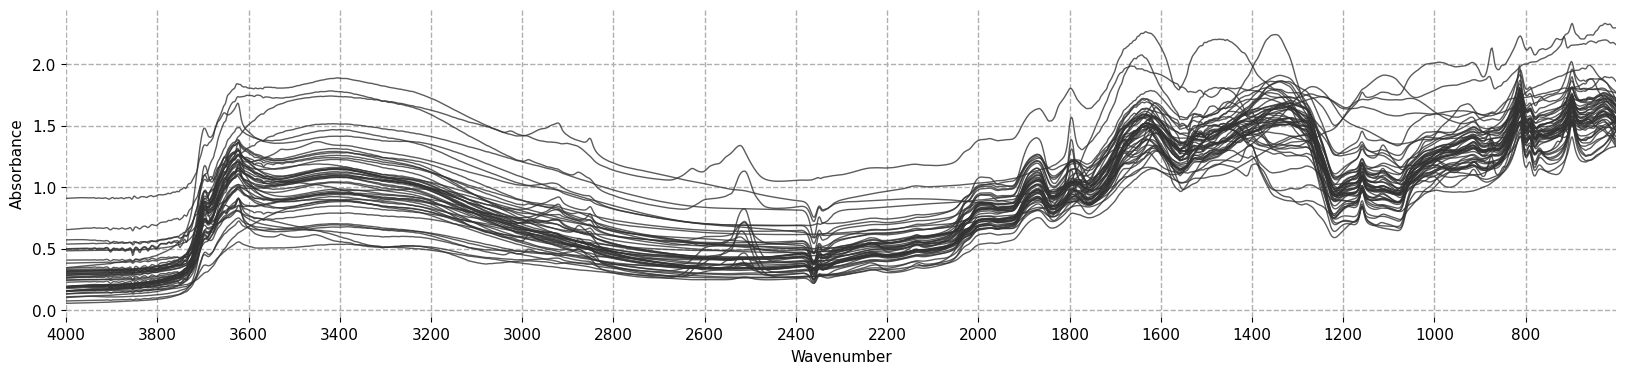

In [ ]:
plot_spectra(X[idxs, :], wns)

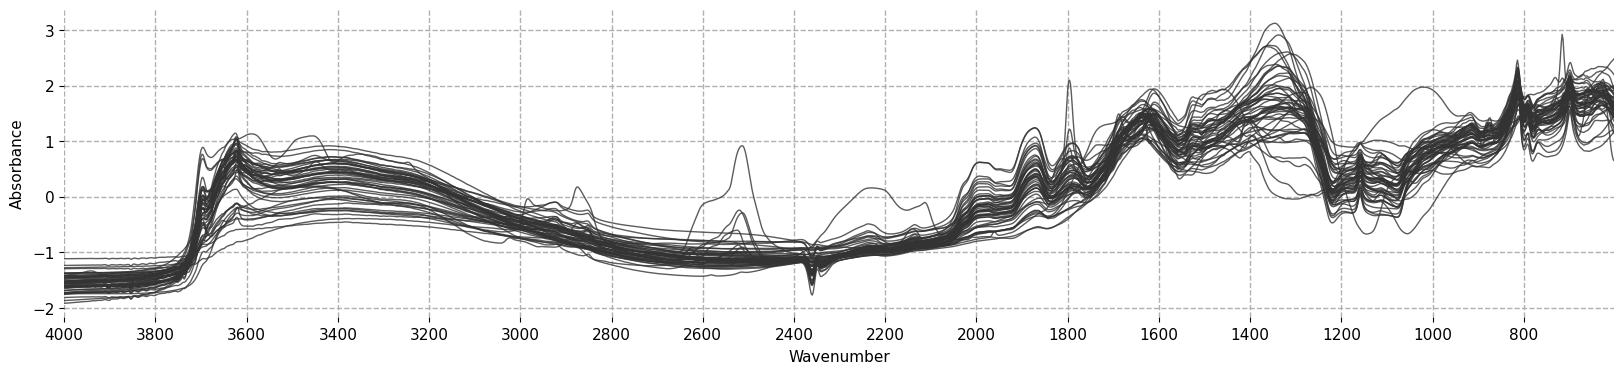

In [ ]:
plot_spectra(SNV().fit_transform(X[idxs, :]), wns)

In [ ]:
n_components = 20
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(SNV().fit_transform(X[idxs, :]))

In [ ]:
# Compute cumulated explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)

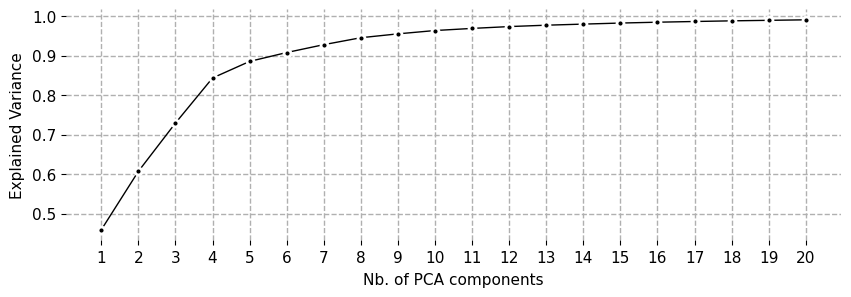

In [ ]:
plot_pca_variance(cumsum, n_components)

In [ ]:
X_pca.shape

(1000, 20)